In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0-dev20201121


In [15]:
import numpy as numpy
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import pathlib


# Set up paths for images

In [3]:
data_dir = pathlib.Path('images')
len(list(data_dir.glob('*/*.jpg')))

3882

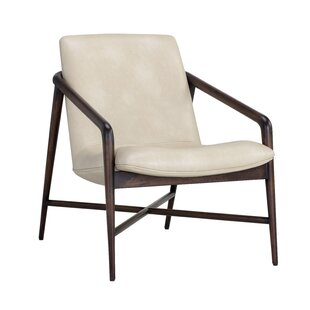

In [4]:
chairs = list(data_dir.glob('chairs/*'))
PIL.Image.open(str(chairs[1]))

# Training / transfer learning model

In [5]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [6]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
batch_size = 64

preprocess_input = tf.keras.applications.vgg16.preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='training',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    subset='validation',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3110 images belonging to 11 classes.
Found 772 images belonging to 11 classes.


In [9]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 7, 7, 512)
(64, 512)


In [10]:
x = base_model.output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc1')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='fc2')(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.2*0.5)(x)
x = tf.keras.layers.Dense(11, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=base_model.input, outputs=x)

In [11]:
base_learning_rate = 0.0001
model_2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model_2.summary()        

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
weights_file = 'vgg16_furniture_classifier_1129.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)


In [13]:
history = model_2.fit(
    train_generator,
    steps_per_epoch=3110//batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=772//batch_size,
    verbose=1,
    workers=4,
    callbacks=[checkpoint,early,tensorboard]
)

Epoch 1/15
48/48 [==============================] - 387s 8s/step - loss: 11.1510 - accuracy: 0.4585 - val_loss: 1.5449 - val_accuracy: 0.7891

Epoch 00001: val_accuracy improved from -inf to 0.78906, saving model to vgg16_furniture_classifier_1129.h5
Epoch 2/15
48/48 [==============================] - 397s 8s/step - loss: 1.3736 - accuracy: 0.7977 - val_loss: 1.5039 - val_accuracy: 0.7891

Epoch 00002: val_accuracy did not improve from 0.78906
Epoch 3/15
48/48 [==============================] - 389s 8s/step - loss: 1.1044 - accuracy: 0.8290 - val_loss: 1.5440 - val_accuracy: 0.7604

Epoch 00003: val_accuracy did not improve from 0.78906
Epoch 4/15
48/48 [==============================] - 370s 8s/step - loss: 0.7721 - accuracy: 0.8599 - val_loss: 1.3126 - val_accuracy: 0.8177

Epoch 00004: val_accuracy improved from 0.78906 to 0.81771, saving model to vgg16_furniture_classifier_1129.h5
Epoch 5/15
48/48 [==============================] - 382s 8s/step - loss: 0.6271 - accuracy: 0.8806 - v

# Plot Accuracy and loss of model

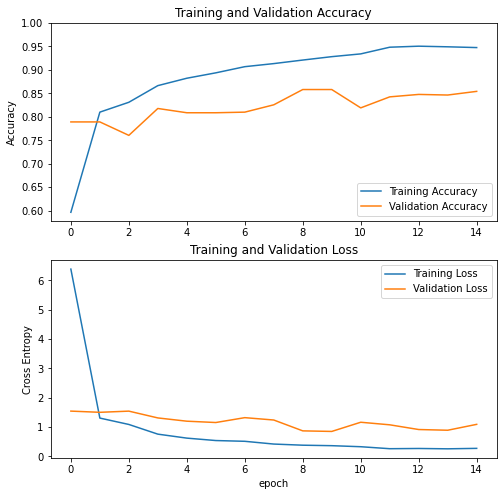

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Visualize Feature maps

In [19]:
from keras.preprocessing import image
preprocess_input = tf.keras.applications.vgg16.preprocess_input
from keras.models import Model
import numpy as np
from matplotlib import pyplot

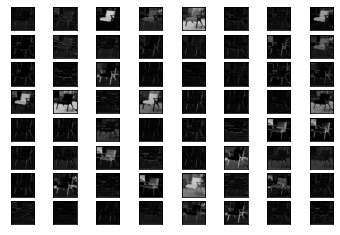

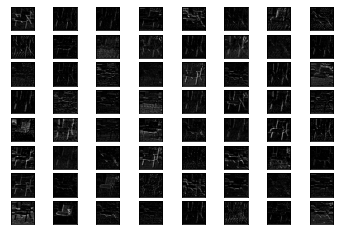

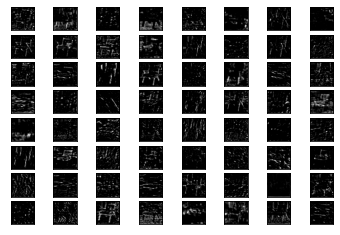

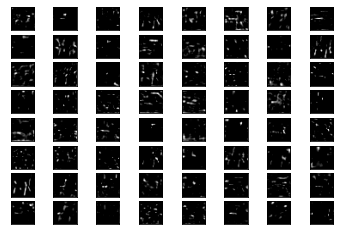

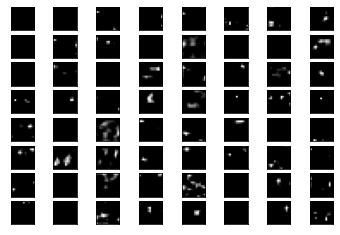

In [24]:
ixs = [2, 5, 9, 13, 17]
outputs = [model_2.layers[i].output for i in ixs]
model = Model(inputs=model_2.inputs, outputs=outputs)
img = image.load_img('images/chairs/chairs1.jpg', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()